In [1]:
c = 299792458
#from direction_rotate import _calc_rotation_mats
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import cngi.conversion.convert_ms as convert_ms
import cngi.conversion.convert_image as convert_image
from cngi.dio import read_vis
import numpy as np
from astropy.coordinates import SkyCoord
from sirius import calc_vis_point
from sympy import *
from astropy.wcs import WCS
import time

In [2]:
#Load Data from converted CASA simulated ms (steal uvw values)
ms_file = 'point_source_sim_vis/mosaic_point_source_sim_dovp_True.vis.zarr' #remember to change pb_parms['pb_func'] = 'casa_airy'
#ms_file = 'point_source_sim_vis/point_source_sim_dovp_False.vis.zarr'
#remember to change pb_parms['pb_func'] = 'none'
#ms_file = 'zenith_point_source_sim_dovp_False.vis.zarr'

In [3]:
mxds = read_vis(ms_file)
print(mxds)

<xarray.Dataset>
Dimensions:           (antenna_ids: 3, feed_ids: 3, field_ids: 2, observation_ids: 1, polarization_ids: 1, source_ids: 2, spw_ids: 1, state_ids: 1)
Coordinates:
  * antenna_ids       (antenna_ids) int64 0 1 2
    antennas          (antenna_ids) <U16 'W01' 'W02' 'W03'
  * field_ids         (field_ids) int64 0 1
    fields            (field_ids) <U5 'fake' 'fake2'
  * feed_ids          (feed_ids) int64 0 0 0
  * observation_ids   (observation_ids) int64 0
    observations      (observation_ids) <U16 'CASA simulation'
  * polarization_ids  (polarization_ids) int64 0
  * source_ids        (source_ids) int64 0 1
    sources           (source_ids) <U5 'fake' 'fake2'
  * spw_ids           (spw_ids) int64 0
  * state_ids         (state_ids) int64 0
Data variables:
    *empty*
Attributes:
    xds0:             <xarray.Dataset>\nDimensions:                (baseline:...
    ANTENNA:          <xarray.Dataset>\nDimensions:        (antenna_id: 3, d1...
    FEED:             <xarray.

In [4]:
vis_xds = read_vis(ms_file).xds0

In [5]:
cas_vis_data = vis_xds.DATA.data.compute()

In [6]:
uvw = vis_xds.UVW.data.compute()

In [7]:
freq_chan = vis_xds.chan.values

In [8]:
cas_vis_data.shape

(10, 3, 3, 2)

### Sirius Simulation

In [9]:
#Setup phase centre (rename pointing_ra_dec to phase_center)
#pointing_ra_dec:  [n_time, n_baseline, 2]                   (singleton: n_time, n_baseline)
phase_center = SkyCoord(ra='20h00m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
phase_center2 = SkyCoord(ra='19h58m28.5s',dec='+40d44m01.5s',frame='fk5')
#To do: concat, check shape
#pointing_skycoord = SkyCoord(ra='0h0m0.0s',dec='90d00m00.0s',frame='fk5') #zenith
phase_center_ra_dec = np.array([phase_center.ra.rad,phase_center.dec.rad]).reshape((1, 2))*np.ones(5).reshape((5, 1))
phase_center_ra_dec2 = np.array([phase_center2.ra.rad,phase_center2.dec.rad]).reshape((1, 2))*np.ones(5).reshape((5, 1))
phase_center_ra_dec = np.append(phase_center_ra_dec, phase_center_ra_dec2, axis = 0)

In [10]:
#Add cell that creates pointing_ra_dec
pointing_ra_dec = np.zeros((1, 1, 2)) #Singleton

In [11]:
phase_center_ra_dec.shape

(10, 2)

In [12]:
#Setup point source skycoord
#point_source_ra_dec:  [n_time, n_point_sources, 2]          (singleton: n_time)
point_source_skycoord = SkyCoord(ra='20h00m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
point_source_skycoord2 = SkyCoord(ra='19h58m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
#point_source_skycoord = SkyCoord(ra='19h59m0.0s',dec='+89d54m01.5s',frame='fk5') #zenith
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]*np.ones(5).reshape(5, 1, 1)
point_source_ra_dec2 = np.array([point_source_skycoord2.ra.rad,point_source_skycoord2.dec.rad])[None,None,:]*np.ones(5).reshape(5, 1, 1)
point_source_ra_dec = np.append(point_source_ra_dec, point_source_ra_dec2, axis = 0)

In [13]:
point_source_ra_dec.shape

(10, 1, 2)

In [14]:
#Source flux
#point_source_flux: [n_time, n_chan, n_pol, n_point_sources] (singleton: n_time, n_chan, n_pol)
point_source_flux = np.array([2.17, 2.17])[None,None,None,:]*np.ones(10).reshape(10, 1, 1, 1)

In [15]:
point_source_flux.shape

(10, 1, 1, 2)

In [16]:
#Primary Beam Model parameters
pb_parms = {}
pb_parms['pb_func'] = 'casa_airy' # casa_airy/airy/none
#pb_parms['pb_func'] = 'none'
pb_parms['dish_diameter'] = 24.5
pb_parms['blockage_diameter'] = 0.0
pb_parms['ipower'] = 1 #CHANGE

In [17]:
n_time, n_baseline, n_chan, n_pol = cas_vis_data.shape
antenna1 = np.zeros(n_baseline)
antenna2 = np.zeros(n_baseline)
n_ant = 1

In [18]:
phase_center_ra_dec.shape

(10, 2)

In [19]:
start = time.time()
vis_data = calc_vis_point.calc_vis(uvw,cas_vis_data.shape,point_source_flux,point_source_ra_dec,pointing_ra_dec,phase_center_ra_dec,antenna1,antenna2,n_ant,freq_chan,pb_parms)
print('Compute Time', time.time()-start)

lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [0. 0. 0.]
lmn is [-6.61253303e-03 -1.88277475e-05  2.18632128e-05]
lmn is [-6.61253303e-03 -1.88277475e-05  2.18632128e-05]
lmn is [-6.61253303e-03 -1.88277475e-05  2.18632128e-05]
lmn is [-6.61253303

In [20]:
abs_dif = np.ravel(np.abs(cas_vis_data[:,:,:,0]-vis_data[:,:,:,0])/np.abs(vis_data[:,:,:,0]))

In [21]:
cas_vis_data.shape

(10, 3, 3, 2)

In [22]:
vis_data.shape

(10, 3, 3, 2)

Text(0, 0.5, 'Relative Change (out of 1)')

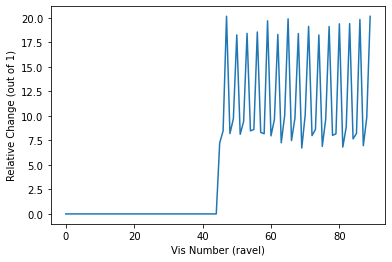

In [23]:
plt.figure()
plt.plot(abs_dif)
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Relative Change (out of 1)')

### Create Image Using ngCASA

In [24]:
#from cngi.vis import apply_flags
from ngcasa.imaging import make_imaging_weight
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from cngi.dio import write_image
import dask
import dask.array as da

In [25]:
rad_to_deg =  180/np.pi
deg_to_rad = np.pi/180
arcsec_to_deg = 1/3600
arcsec_to_rad = np.pi/(180*3600)

In [26]:
#mxds = apply_flags(mxds, 'xds0', flags='FLAG')
mxds.attrs['xds1'] = mxds.attrs['xds0'].isel(pol=slice(0,1))
mxds.attrs['xds1']['DATA'] = xr.DataArray(da.from_array(vis_data[:,:,:,0][:,:,:,None],chunks=mxds.attrs['xds1']['DATA'].chunks),coords=mxds.attrs['xds1']['DATA'].coords)

In [27]:
from ngcasa.imaging import direction_rotate
xr.set_options(display_style="html")

In [28]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [800,400]
grid_parms['cell_size'] = [5,5]
grid_parms['phase_center'] = (mxds.FIELD.PHASE_DIR[0,0,:].data.compute() + mxds.FIELD.PHASE_DIR[1,0,:].data.compute())/2

In [29]:
mxds.xds1.data_groups

[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'CORRECTED_DATA',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW',
   'weight': 'CORRECTED_DATA_WEIGHT'}}]

In [30]:
sel_parms = {}
sel_parms['xds'] = 'xds1' #KEEP USING XDS1 THROUGHOUT
sel_parms['data_group_in_id'] = 0 #CHANGE TO DATA GROUP 2 AFTER ROTATION

rotation_parms = {}
rotation_parms['new_phase_center'] = grid_parms['phase_center']
rotation_parms['common_tangent_reprojection'] = True
rotation_parms['single_precision'] = False

mxds = direction_rotate(mxds, rotation_parms, sel_parms)

######################### Start direction_rotate #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
######################### Created graph for direction_rotate #########################


In [31]:
mxds.xds1.data_groups

[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'CORRECTED_DATA',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW',
   'weight': 'CORRECTED_DATA_WEIGHT'},
  '2': {'data': 'DATA_ROT',
   'flag': 'FLAG',
   'id': '2',
   'uvw': 'UVW_ROT',
   'weight': 'DATA_WEIGHT'}}]

In [32]:
imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

In [33]:
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2

In [34]:
mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


In [35]:
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

In [36]:
img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

In [37]:
from cngi.dio import write_image
write_imagegrid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [800,400]
grid_parms['cell_size'] = [5,5]
grid_parms['phase_center'] = (mxds.FIELD.PHASE_DIR[0,0,:].data.compute() + mxds.FIELD.PHASE_DIR[1,0,:].data.compute())/2
gcf_parms = {}
gcf_parms['function'] = 'alma_airy'
gcf_parms['list_dish_diameters'] = np.array([24.5])
gcf_parms['list_blockage_diameters'] = np.array([0])
gcf_parms['max_support'] = [24, 24]
gcf_parms['oversampling'] = [10, 10]
unique_ant_indx = mxds.ANTENNA.DISH_DIAMETER.values
unique_ant_indx[unique_ant_indx == 25.0] = 0
mxds.ANTENNA.DISH_DIAMETER.values
gcf_parms['unique_ant_indx'] = unique_ant_indx.astype(int)
gcf_parms['phase_center'] = grid_parms['phase_center']
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2
gcf_xds = make_gridding_convolution_function(mxds, gcf_parms, grid_parms, sel_parms)
dask.compute(gcf_xds)

NameError: name 'make_gridding_convolution_function' is not defined

In [46]:
from ngcasa.imaging import make_image_with_gcf
from ngcasa.imaging import make_mosaic_pb
img_xds = xr.Dataset() #empty dataset
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

img_xds = make_mosaic_pb(mxds,gcf_xds,img_xds,vis_sel_parms,img_sel_parms,grid_parms)

vis_select_parms = {}
vis_select_parms['xds'] = 'xds1'
vis_select_parms['data_group_in_id'] = 2

img_select_parms = {}
img_select_parms['data_group_in_id'] = 0
img_select_parms['data_group_out_id'] = 0

norm_parms = {}
norm_parms['norm_type'] = 'flat_sky'

img_xds = make_image_with_gcf(mxds,gcf_xds, img_xds, grid_parms, norm_parms, vis_select_parms, img_select_parms)
#Need make_image_with_gcf instead of make_image, add make_gridding_convolutional_function, direction_rotate
#Note: if no primary beam, use 'flat_noise' instead of 'flat_sky'

NameError: name 'gcf_xds' is not defined

In [38]:
img_xds.data_groups

NameError: name 'img_xds' is not defined

In [39]:
mxds.xds1.data_groups

[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'CORRECTED_DATA',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW',
   'weight': 'CORRECTED_DATA_WEIGHT'},
  '2': {'data': 'DATA_ROT',
   'flag': 'FLAG',
   'id': '2',
   'uvw': 'UVW_ROT',
   'weight': 'DATA_WEIGHT',
   'imaging_weight': 'DATA_WEIGHT'}}]

In [40]:
#Select chan 1
chan = 1
ngcasa_image_name = 'IMAGE'
pb_limit = 0.2
#extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

mosaic_pb = img_xds.PB.isel(chan=chan)
mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
mosaic_img = mosaic_img.where(mosaic_pb > np.max(mosaic_pb)*pb_limit,other=np.nan)

NameError: name 'img_xds' is not defined

In [41]:
mosaic_img

NameError: name 'mosaic_img' is not defined

In [42]:
mosaic_img[:, :, 0, 0]

NameError: name 'mosaic_img' is not defined

In [43]:
plt.figure()
#plt.imshow(img_xds.IMAGE.isel(chan=chan,time=0,pol=0))
plt.imshow(mosaic_img[:, :, 0, 0])

NameError: name 'mosaic_img' is not defined

<Figure size 432x288 with 0 Axes>

### Calculate Pixel Position

In [44]:
phase_center = grid_parms['phase_center']
w = WCS(naxis=2)
w.wcs.crpix = np.array(grid_parms['image_size'])//2
w.wcs.cdelt = np.array([-20,20])*arcsec_to_deg
w.wcs.crval = phase_center*rad_to_deg
w.wcs.ctype = ['RA---SIN','DEC--SIN']

In [45]:
lm_pix_pos = w.all_world2pix(point_source_ra_dec[0,:,:]*rad_to_deg, 1)
print('source pix pos',lm_pix_pos)

source pix pos [[365.90135428 200.048544  ]]


In [83]:
lm_pix_pos = w.all_world2pix(pointing_ra_dec[0,:,:]*rad_to_deg, 1)
print('source pix pos',lm_pix_pos)

source pix pos [[ 65.90135428 200.048544  ]
 [134.268903   140.04912485]]


In [42]:
cell_size = np.array(grid_parms['cell_size'])*arcsec_to_rad
cell_size[0] = -cell_size[0]
image_center = np.array(grid_parms['image_size'])//2
source_lm_pos = lm_pix_pos*cell_size - image_center*cell_size
print('source lm pos',source_lm_pos)

source lm pos [[-0.00156774  0.00203728]]


### Plot Primary Beam

In [4]:
from sirius._sirius_utils._make_pb_symmetric import _casa_airy_disk

In [58]:
grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = np.array([200,400])
grid_parms['cell_size'] = np.array([-20,20])*arcsec_to_rad
grid_parms['phase_center'] = pointing_ra_dec[0,0,:]
pol = [1]
grid_parms['image_center'] = grid_parms['image_size']//2

grid_parms2 = {}
grid_parms2['chan_mode'] = 'continuum'
grid_parms2['image_size'] = np.array([200,400])
grid_parms2['cell_size'] = np.array([-20,20])*arcsec_to_rad
grid_parms2['phase_center'] = pointing_ra_dec2[0,0,:]
pol = [1]
grid_parms2['image_center'] = grid_parms['image_size']//2

In [59]:
pb_parms = {}
pb_parms['pb_func'] = 'casa_airy'
pb_parms['list_dish_diameters'] = [24.5] #Can make this smaller for larger primary beam
pb_parms['list_blockage_diameters'] = [0.0]
pb_parms['ipower'] = 2

In [60]:
pointing_ra_dec[0, :, :]

array([[5.23369701, 0.71093805],
       [4.95008101, 0.70512029]])

In [61]:
pointing_ra_dec2

array([[[4.95008101, 0.70512029]]])

In [62]:
pb = _casa_airy_disk(freq_chan,pol,pb_parms,grid_parms)
pb2 = _casa_airy_disk(freq_chan,pol,pb_parms,grid_parms2)

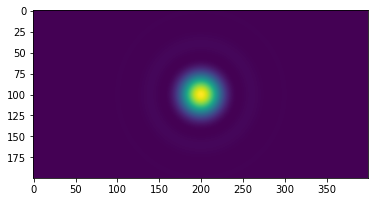

In [63]:
plt.figure()
plt.imshow(pb[:,:,1,0,0])
#plt.imshow(pb2[:,:,1,0,0])

plt.show()